<a href="https://colab.research.google.com/github/tinghe14/-Coursera-/blob/main/Code_Sample_for_Kensho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#---------------------------------------#
#--------CONCLUSION---------#
#---------------------------------------#
In this sample code of classifying whether tweets are misleading or not, I ran 2 models. 
The baseline model is random forest which I tuned some hyperparameters such as depth of the tree. 
After conduct 3 fold cross validation, the best preformance of model achive F1 score at 0.90 in the training dataset. 
For improving our baseline model, I used the transfer learning model, DistillBERT, and fine tuned in my task, which achived F1 score at 0.99 in the training dataset, and 0.98 in the test dataset.

In [1]:
#pip3 install defaultlist
import nltk

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import pandas as pd
import numpy as np
from defaultlist import defaultlist
import matplotlib.pyplot as plt
from scipy.sparse import hstack

from time import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc 
from pprint import pprint

import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
stop_words.add("amp")
from wordcloud import WordCloud, ImageColorGenerator

In [3]:
#!pip3 install transformers

from transformers import BertTokenizer
import torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#--------DATA LOADING--------#
data = pd.read_csv("clean_data.csv")
print("shape of whole data: ", data.shape)
# keep important columns
df = data[['favorite_count', 'retweet_count',  'user_favourites_count',
       'user_followers_count', 'user_friends_count', 'user_listed_count',
       'user_statuses_count', 'user_verified', 'is_misinfo', 'polarity',
       'subjectivity','text']]
print("shape of data: ", df.shape)
print("list of data feature:", df.columns)

shape of whole data:  (12365, 24)
shape of data:  (12365, 12)
list of data feature: Index(['favorite_count', 'retweet_count', 'user_favourites_count',
       'user_followers_count', 'user_friends_count', 'user_listed_count',
       'user_statuses_count', 'user_verified', 'is_misinfo', 'polarity',
       'subjectivity', 'text'],
      dtype='object')


In [ ]:
#--------PART OF EDA--------#
# imbalanced check:
print("precentage of misleading tweets: {:0.2f}%".format(sum(df['is_misinfo']==1.0) /df.shape[0]))
# check variables types:
print(df.info())
# check tweets:
print(df['text'].head(10))

precentage of misleading tweets: 0.34%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12365 entries, 0 to 12364
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   favorite_count         12365 non-null  float64
 1   retweet_count          12365 non-null  float64
 2   user_favourites_count  12365 non-null  float64
 3   user_followers_count   12365 non-null  float64
 4   user_friends_count     12365 non-null  float64
 5   user_listed_count      12365 non-null  float64
 6   user_statuses_count    12365 non-null  float64
 7   user_verified          12365 non-null  float64
 8   is_misinfo             12365 non-null  float64
 9   polarity               12365 non-null  float64
 10  subjectivity           12365 non-null  float64
 11  text                   12365 non-null  object 
dtypes: float64(11), object(1)
memory usage: 1.1+ MB
None
0    My 87 year old grandmother has been quarantini...
1    I’m so

In [5]:
#--------PREPROCESSING--------#
def pre_process(data, flg_stemm = False):
  # @input: pandas series 
  # @output: clean pandas series
  result = []
  refer = defaultlist(defaultlist())
  for line in data:
    # clean (convert to lowercase, remove punctuations and numbers and then strip)
    line = re.sub(r'[^\w\s]', '', str(line).lower().strip())
    clean_tokens = line.split()
    # remove stop words
    stopwords = nltk.corpus.stopwords.words("english")
    non_stop = [clean_non_stop for clean_non_stop in clean_tokens if clean_non_stop not in stopwords]
    # remove website link by remove any string begin with https
    prefix = 'https' or 'https'
    non_stop_wo_website = [x for x in non_stop if not x.startswith(prefix)]
    # stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
      ps = nltk.stem.porter.PorterStemmer()
      non_stop_ps = [ps.stem(word) for word in non_stop_wo_website]
      text = " ".join(non_stop_ps)
    else:
      text = " ".join(non_stop_wo_website)
    result.append(text)
  return result

df['clean text'] = pre_process(df['text'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0    87 year old grandmother quarantining florida h...
1    im excited vaccine see day get back work thank...
2    excited able close 2020 positive note getting ...
3    well happened daughter used grandchildren try ...
4    im getting covid19 vaccine baby im fucking exc...
5    hmmm idaho 56225 covid vaccines available 1578...
6    excited grateful ending 2020 first dose corona...
7    found wife getting vaccine two weeks excited j...
8    chris rock excited get covid vaccine know what...
9    56225 covid vaccines available 15780 administe...
Name: clean text, dtype: object
---word clouds for whole tweets---
---word clouds for misleading tweets---
---word clouds for non-misleading tweets---


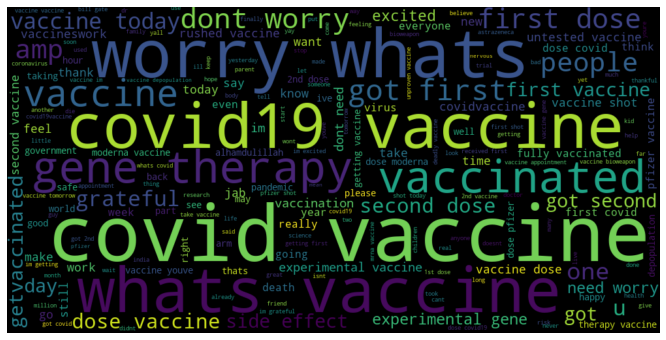

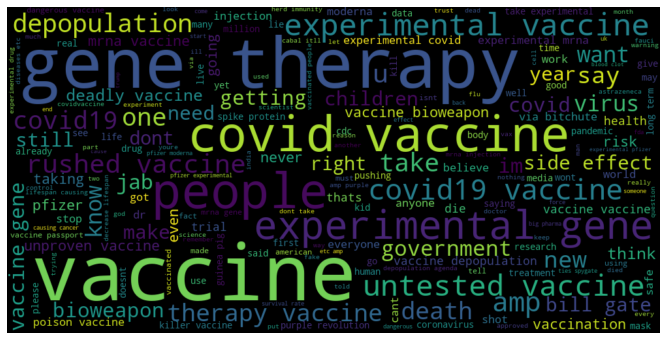

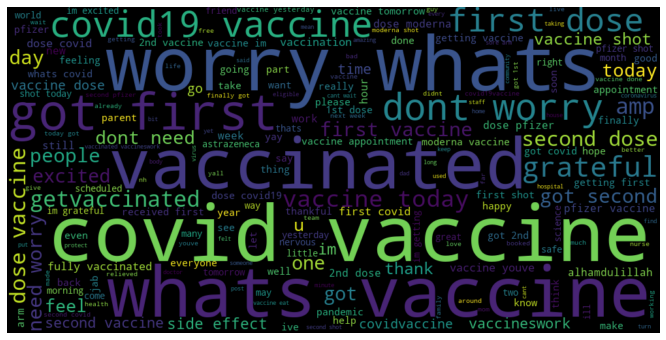

In [ ]:
#--------PART OF EDA--------#
# check tweets:
print(df['clean text'].head(10))

# word clouds
def wordcloud(data):
  words = ' '.join([word for word in data['clean text']])
  word_cloud = WordCloud(width=1000, height=500, random_state=20, max_font_size=120).generate(words)
  fig, ax = plt.subplots(figsize=(12,6))
  plt.imshow(word_cloud, interpolation='bilinear')
  plt.axis('off')
print("---word clouds for whole tweets---")
wordcloud(df)
print("---word clouds for misleading tweets---")
df_mis = df[df['is_misinfo']==1]
wordcloud(df_mis)
print("---word clouds for non-misleading tweets---")
df_mis = df[df['is_misinfo']==0]
wordcloud(df_mis)

# vocabulary size

In [6]:
#--------DATA SPLITING--------#
x_variable = df.columns[~(df.columns.isin(['is_misinfo', 'text']))]
X = df[x_variable].values
y = df['is_misinfo'].values

X_train0, X_test0, y_train, y_test = train_test_split( # already shuffle
    X, y,
    test_size=0.2,
    random_state=0
)

In [ ]:
#--------VECTORIZE TEXT--------#
t0 = time()
vectorizer = TfidfVectorizer(max_df=0.8, max_features=100) # ignore all words that have appeared in 80% of the document
X_train_tfidf = vectorizer.fit_transform(X_train0[:,-1])
print("time spent on vectorized train data :", time()-t0)
t0 = time()
vectorizer2 = TfidfVectorizer(max_df=0.8, max_features=100, vocabulary=vectorizer.vocabulary_)
X_test_tfidf = vectorizer2.fit_transform(X_test0[:,-1])
print("time spent on vectorized test data :", time()-t0)

time spent on vectorized train data : 0.33312082290649414
time spent on vectorized test data : 0.07185220718383789


In [ ]:
#--------CONCATENATE FEATURES--------#
print("shape of tfidf in train data: ", X_train_tfidf.shape)
print("shape of tfidf in test data: ", X_test_tfidf.shape)

X_train = np.delete(X_train0, -1, axis=1)
X_train = hstack([np.array(X_train0, dtype="float"), X_train_tfidf])

X_test = np.delete(X_test0, -1, axis=1)
X_test = hstack([np.array(X_test0, dtype="float"), X_test_tfidf])

print("shape of train data: ", X_train.shape)
print("shape of test data: ", X_test.shape)

shape of tfidf in train data:  (9892, 100)
shape of tfidf in test data:  (2473, 100)
shape of train data:  (9892, 110)
shape of test data:  (2473, 110)


In [ ]:
#--------BASELINE MODEL: RANDOM FOREST + TF-IDF--------#
rfc = RandomForestClassifier(random_state=0)

#--------HYPERPRAMETER TUNING--------#
# number of trees
rf_n_estimators = [int(x) for x in np.linspace(20, 30, 10)]
# number of features in tree
rf_max_features = [int(x) for x in np.linspace(5, 10, 1)]
# maixmun tree depth
rf_max_depth = [int(x) for x in np.linspace(10, 20)]
# criterion to split on
rf_criterion = ['gini', 'entropy']
# final grid
rf_grid = {'n_estimators': rf_n_estimators,
           'max_depth': rf_max_depth,
           'criterion': rf_criterion,
           'max_features': rf_max_features}

rf = RandomizedSearchCV(estimator=rfc, param_distributions=rf_grid, scoring=make_scorer(f1_score), 
                        n_iter=10, cv=3,random_state=0, return_train_score=True)

rf.fit(X_train, y_train)
print(rf.best_params_)
print("---------------------------")
print(rf.best_score_) # F1 score
print("---------------------------")
print(rf.best_estimator_)


{'n_estimators': 30, 'max_features': 5, 'max_depth': 17, 'criterion': 'gini'}
---------------------------
0.9057569742435424
---------------------------
RandomForestClassifier(max_depth=17, max_features=5, n_estimators=30,
                       random_state=0)


In [ ]:
print("---------------------------")
print(rf.cv_results_)

---------------------------
{'mean_fit_time': array([0.39996505, 0.42647862, 0.43045584, 0.31766653, 0.61268298,
       0.5533011 , 0.48389101, 0.49919963, 0.30012711, 0.45687207]), 'std_fit_time': array([0.02323268, 0.06016165, 0.05206998, 0.0818605 , 0.21882387,
       0.16219232, 0.01488424, 0.04592931, 0.04073737, 0.0739824 ]), 'mean_score_time': array([0.02431424, 0.02757517, 0.02513138, 0.0209101 , 0.04954123,
       0.03183301, 0.04120413, 0.04700605, 0.0289584 , 0.03792667]), 'std_score_time': array([0.00527128, 0.00293434, 0.00033885, 0.00035041, 0.02570953,
       0.01411919, 0.02289636, 0.01919568, 0.00725258, 0.0179991 ]), 'param_n_estimators': masked_array(data=[24, 30, 30, 22, 25, 23, 27, 30, 30, 23],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_max_features': masked_array(data=[5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
             mask=[False, False, False, Fals

In [ ]:
#--------VISUAL RESULTS--------#
importances = list(rf.best_estimator_.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(x_variable, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: favorite_count       Importance: 0.03
Variable: polarity             Importance: 0.03
Variable: user_friends_count   Importance: 0.02
Variable: retweet_count        Importance: 0.01
Variable: user_favourites_count Importance: 0.01
Variable: user_followers_count Importance: 0.01
Variable: user_listed_count    Importance: 0.01
Variable: user_statuses_count  Importance: 0.01
Variable: subjectivity         Importance: 0.01
Variable: user_verified        Importance: 0.0
Variable: clean text           Importance: 0.0


In [7]:
#--------2ND EXPERIEMENT: BERT MODEL--------#

#--------BASIC SETTING--------#
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

X_train1, X_val1, y_train, y_val =\
    train_test_split(X_train0, y_train, test_size=0.1, random_state=0)

#--------BERT TOKENIZER--------#
# to apply bert model, we need to use the tokenizer provided by libary
# because (1) the model has a specific, fix vocabulary and (2) the BERT tokenizer has particular way of handling out-of-vocabulary words
# and also need to add special tokens to the start and end of each stences, pad & truncate all senetences to a single constant length
# and explicigty specify what are padding tokens with the 'attention marsk'

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text = sent,
            truncation = True,
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

# before tokenizing, we need to specify the maximum length of sentences
# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in df['clean text']] # all text
# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

There are 1 GPU(s) available.
Device name: Tesla T4
Max length:  78


In [8]:
#--------APPLY BERT TOKENIZER--------#
MAX_LEN = 78

# Run function `preprocessing_for_bert` on the train set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train1[:,-1]) #clean text
val_inputs, val_masks = preprocessing_for_bert(X_val1[:,-1])

Tokenizing data...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [9]:
#--------CREATE DATA LOADER FOR BERT--------#
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train).type(torch.LongTensor)
val_labels = torch.tensor(y_val).type(torch.LongTensor)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [10]:
#--------TRAIN BERT MODEL--------#
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

# optimizer & learning rate scheduler
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
  """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
  """
  # Instantiate Bert Classifier
  bert_classifier = BertClassifier(freeze_bert=False)

  # Tell PyTorch to run the model on GPU
  bert_classifier.to(device)

  # Create the optimizer
  optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                    )
    
  #y_pred = np.where(preds >= 0.5, 1, 0)
  # Total number of training steps
  total_steps = len(train_dataloader) * epochs

  # Set up the learning rate scheduler
  scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
  return bert_classifier, optimizer, scheduler

CPU times: user 39.5 ms, sys: 21 µs, total: 39.5 ms
Wall time: 40.8 ms


In [16]:
#--------BERT TRAINING--------#
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=0):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
            
            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
              #print(logits.dtype) float->float32
              #print(b_labels.dtype) double-> float64
            b_labels = b_labels.to(torch.int64)
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        b_labels = b_labels.to(torch.int64)
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.464622   |     -      |     -     |   8.95   
   1    |   40    |   0.232889   |     -      |     -     |   8.64   
   1    |   60    |   0.203351   |     -      |     -     |   8.86   
   1    |   80    |   0.142816   |     -      |     -     |   8.94   
   1    |   100   |   0.070990   |     -      |     -     |   8.84   
   1    |   120   |   0.106856   |     -      |     -     |   8.68   
   1    |   140   |   0.083312   |     -      |     -     |   8.56   
   1    |   160   |   0.119984   |     -      |     -     |   8.64   
   1    |   180   |   0.046589   |     -      |     -     |   8.52   
   1    |   200   |   0.056254   |     -      |     -     |   8.51   
   1    |   220   |   0.102571   |     -      |     -     |   8.57   
   1    |   240   |   0.065510   |     -      |     -     |   8.68   


AUC: 0.9986
Accuracy at 0.5: 99.29%
The optimal threshold value is: 0.23019601


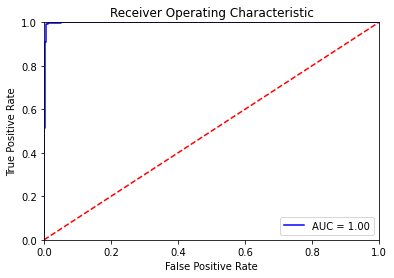

In [19]:
#--------BERT Validated on Validation set--------#
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy at 0.5: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = threshold[optimal_idx]
    print("The optimal threshold value is:", optimal_threshold)
    plt.show()

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

In [22]:
train_pred_thr = np.where(probs[:,1] > 0.23, 1, 0)
f1 = f1_score(train_pred_thr, y_val)
print("F1 score for training data: ", f1)

F1 score for training data:  0.9913793103448276


In [18]:
#--------BERT Train on Entire Training Data--------#
# Concatenate the train set and the validation set
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, full_train_dataloader, epochs=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.442947   |     -      |     -     |   9.12   
   1    |   40    |   0.165597   |     -      |     -     |   8.61   
   1    |   60    |   0.104589   |     -      |     -     |   8.65   
   1    |   80    |   0.116412   |     -      |     -     |   8.67   
   1    |   100   |   0.085674   |     -      |     -     |   8.64   
   1    |   120   |   0.161907   |     -      |     -     |   8.60   
   1    |   140   |   0.100195   |     -      |     -     |   8.63   
   1    |   160   |   0.105561   |     -      |     -     |   8.69   
   1    |   180   |   0.087142   |     -      |     -     |   8.61   
   1    |   200   |   0.046040   |     -      |     -     |   8.58   
   1    |   220   |   0.096083   |     -      |     -     |   8.60   
   1    |   240   |   0.071633   |     -      |     -     |   8.64   


Tokenizing data...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


AUC: 0.9988
Accuracy at 0.5: 98.63%
The optimal threshold value is: 0.01018501


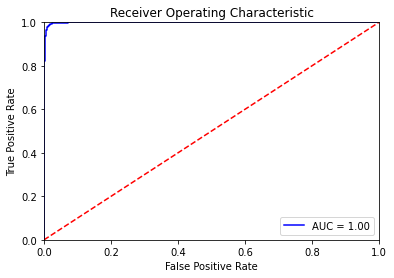

In [38]:
#---------------------------------------#
#--------PREDICTION ON TEST DATA--------#
#---------------------------------------#
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(X_test0[:,-1])

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.23
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Evaluate the Bert classifier
evaluate_roc(probs, y_test)

In [40]:
train_pred_thr = np.where(probs[:,1] > 0.23, 1, 0)
f1 = f1_score(train_pred_thr, y_test)
print("F1 score for training data: ", f1)

F1 score for training data:  0.979689366786141


#---------------------------------------#
#--------CONCLUSION---------#
#---------------------------------------#
In this sample code of classifying whether tweets are misleading or not, I ran 2 models. 
The baseline model is random forest which I tuned some hyperparameters such as depth of the tree. 
After conduct 3 fold cross validation, the best preformance of model achive F1 score at 0.90 in the training dataset. 
For improving our baseline model, I used the transfer learning model, DistillBERT, and fine tuned in my task, which achived F1 score at 0.99 in the training dataset, and 0.98 in the test dataset.